<a href="https://colab.research.google.com/github/paritachavda/Computer-Vision/blob/master/Camera_Calibration_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


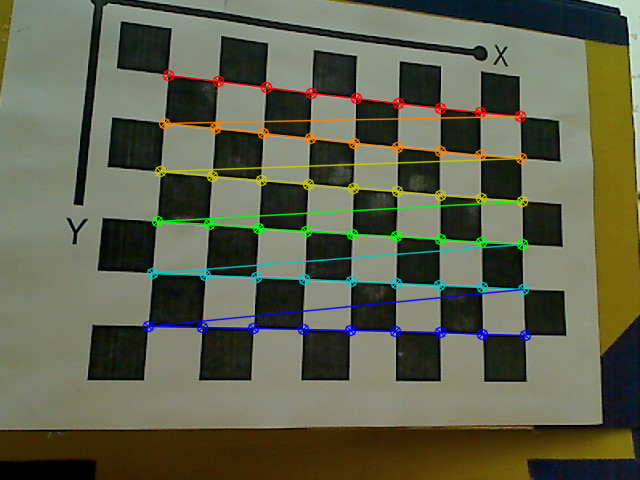

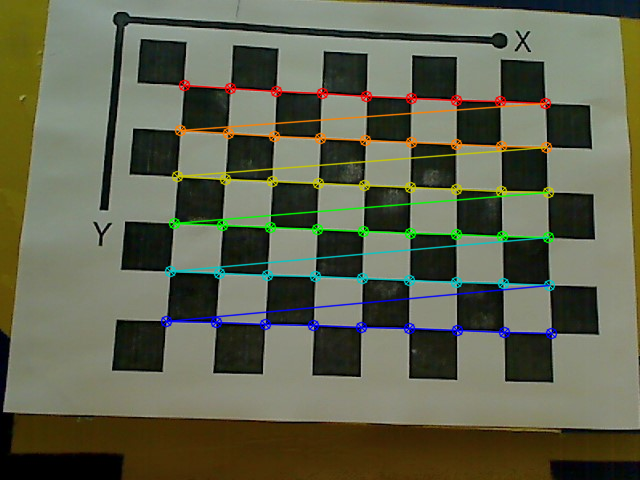

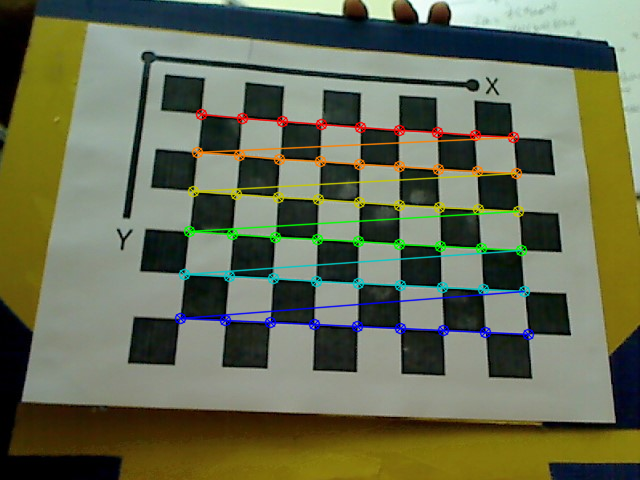

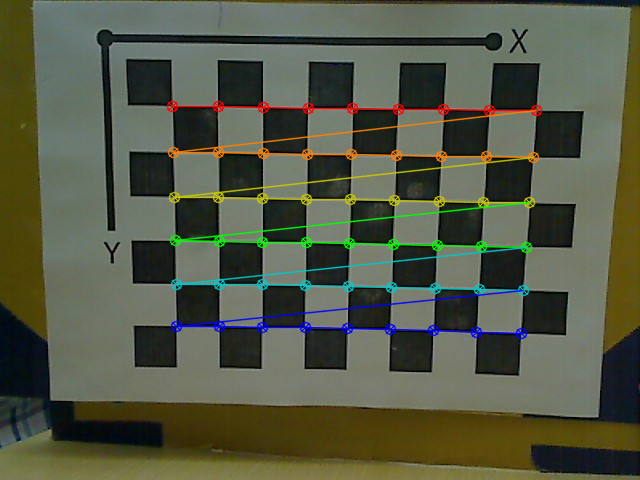

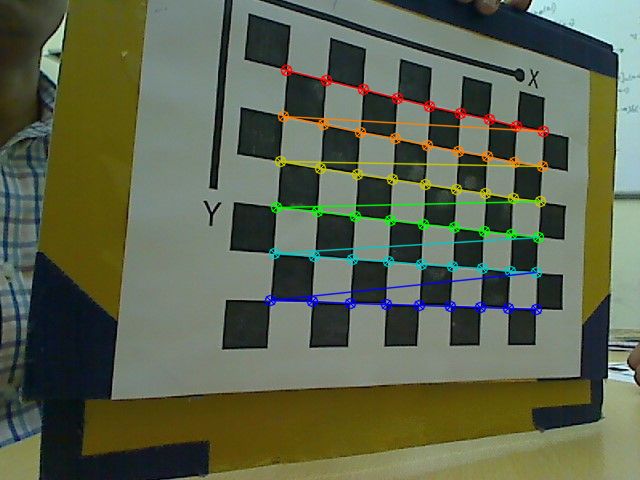

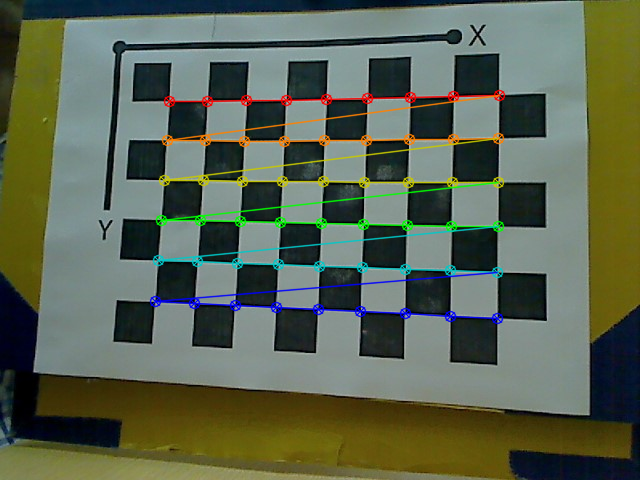

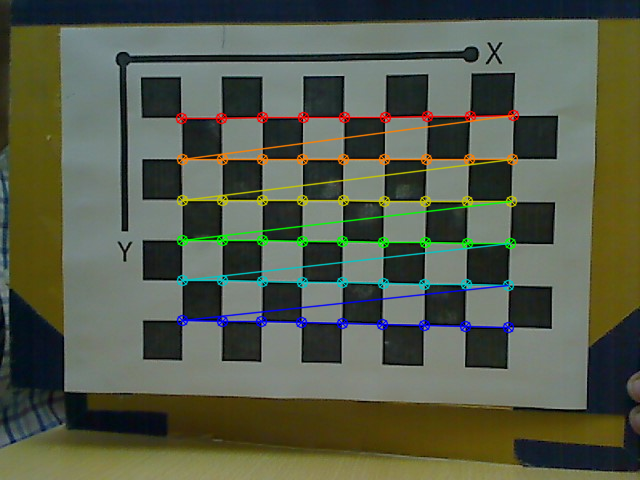

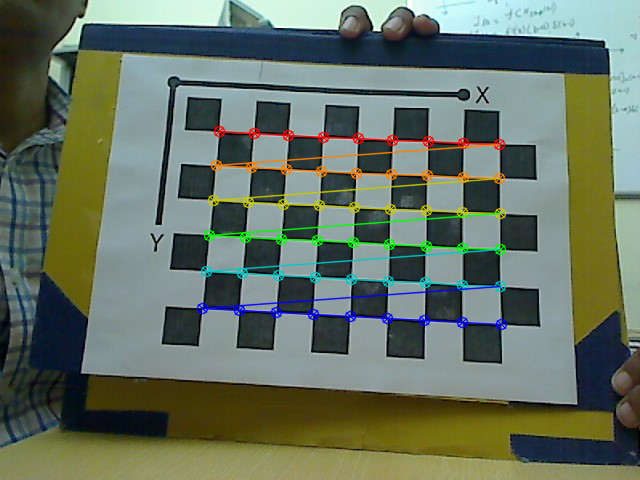

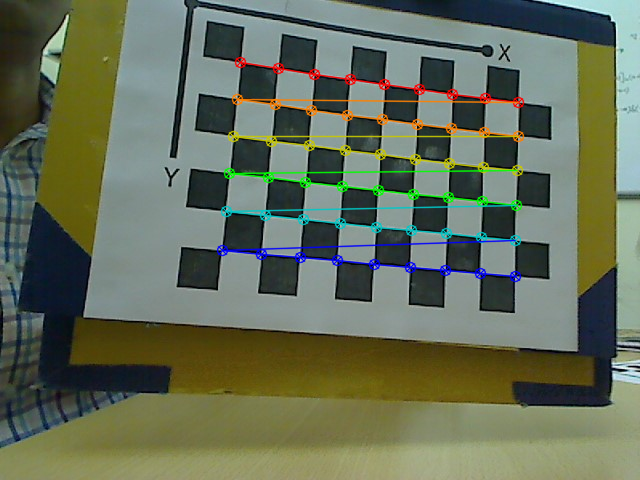

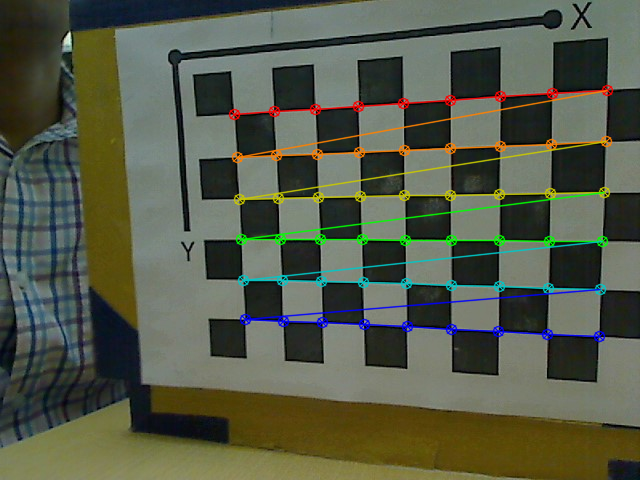

In [0]:
from mpl_toolkits.mplot3d import Axes3D 

from matplotlib import cm
from numpy import linspace

import numpy as np
import cv2 
import matplotlib.pyplot as plt

import os
from multiprocessing.dummy import Pool as ThreadPool
import argparse
from argparse import RawTextHelpFormatter
import glob
import pickle
import pandas as pd

%matplotlib inline
import glob
from google.colab.patches import cv2_imshow


criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


objpoints = [] 
imgpoints = [] 

images = glob.glob('/content/drive/My Drive/computer vision/chessboard/*.jpg')
# cv2_imshow(images)

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
#     print(corners)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        
        img = cv2.drawChessboardCorners(img, (9,6), corners2,ret)
        cv2_imshow(img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [0]:
rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [0]:
rms

0.34000638326988525

In [0]:
camera_matrix

array([[541.47447637,   0.        , 318.33133616],
       [  0.        , 546.03331931, 221.85272894],
       [  0.        ,   0.        ,   1.        ]])

In [0]:
img = cv2.imread('/content/drive/My Drive/computer vision/chessboard/WIN_20190911_17_46_39_Pro.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(camera_matrix,dist_coefs,(w,h),1,(w,h))

In [0]:
dst = cv2.undistort(img, camera_matrix, dist_coefs, None, newcameramtx)

x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('calibresult.png',dst)

True

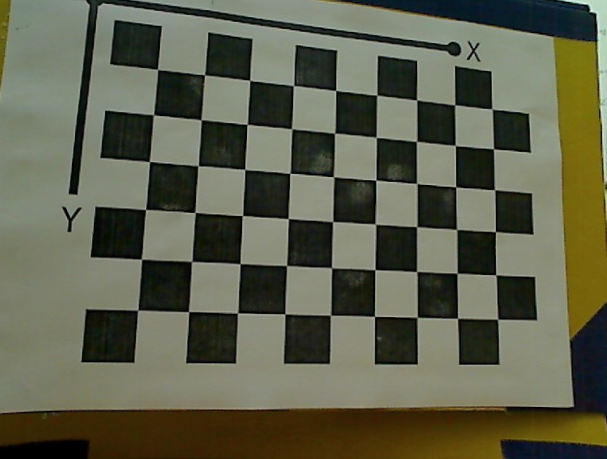

In [0]:
cv2_imshow(dst)

In [0]:
mean_error = 0
tot_error=0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], camera_matrix, dist_coefs)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    tot_error += error
mean_error = tot_error/len(objpoints)
# print(mean_error)
print(tot_error)

0.4516585162886598


In [0]:
 def visualize_calibration_boards(cam_width = 20.0,cam_height = 10.0,scale_focal = 40):
               
        # Plot the camera centric view
        visualize_views(camera_matrix,
                        rvecs,
                        tvecs,
                        board_width=7,
                        board_height=6,
                        square_size=10,
                        cam_width = 10,
                        cam_height = 5,
                        scale_focal = 40,
                        patternCentric = False                                              
                        )
        # Plot the pattern centric view
        visualize_views(camera_matrix,rvecs,tvecs,
                        board_width=7,
                        board_height=6,
                        square_size=10,
                        cam_width = 10,
                        cam_height = 5,
                        scale_focal = 40,
                        patternCentric = True                                              
                        )




In [0]:
def visualize_views(camera_matrix,
                      rvecs,
                      tvecs,
                      board_width,
                      board_height,
                      square_size,
                      cam_width = 64/2,
                      cam_height = 48/2,
                      scale_focal = 40,
                      patternCentric = False,
                      figsize = (8,8)):
                     
   
    i = 0
    extrinsics = np.zeros((len(rvecs),6))
    for rot,trans in zip(rvecs,tvecs):
        extrinsics[i]=np.append(rot.flatten(),trans.flatten())
        i+=1
    
    
    fig = plt.figure(figsize=figsize)
    ax = Axes3D(fig)
    ax.set_aspect("equal")

    min_values, max_values = _draw_camera_boards(ax, camera_matrix, cam_width, cam_height,
                                                scale_focal, extrinsics, board_width,
                                                board_height, square_size, patternCentric)

    X_min = min_values[0]
    X_max = max_values[0]
    Y_min = min_values[1]
    Y_max = max_values[1]
    Z_min = min_values[2]
    Z_max = max_values[2]
    max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0

    mid_x = (X_max+X_min) * 0.5
    mid_y = (Y_max+Y_min) * 0.5
    mid_z = (Z_max+Z_min) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('-y')
    if patternCentric:
        ax.set_title('Pattern Centric View')
        
            
    else:
        ax.set_title('Camera Centric View')
        
    plt.show(fig)   

In [0]:
def _draw_camera_boards(ax, camera_matrix, cam_width, cam_height, scale_focal,
                       extrinsics, board_width, board_height, square_size,
                       patternCentric):
    # util function
    min_values = np.zeros((3,1))
    min_values = np.inf
    max_values = np.zeros((3,1))
    max_values = -np.inf

    if patternCentric:
        X_moving = _create_camera_model(camera_matrix, cam_width, cam_height, scale_focal)
        X_static = _create_board_model(extrinsics, board_width, board_height, square_size)
    else:
        X_static = _create_camera_model(camera_matrix, cam_width, cam_height, scale_focal, True)
        X_moving = _create_board_model(extrinsics, board_width, board_height, square_size)

    cm_subsection = np.linspace(0.0, 1.0, extrinsics.shape[0])
    colors = [ cm.jet(x) for x in cm_subsection ]

    for i in range(len(X_static)):
        X = np.zeros(X_static[i].shape)
        for j in range(X_static[i].shape[1]):
            X[:,j] = _transform_to_matplotlib_frame(np.eye(4), X_static[i][:,j])
        ax.plot3D(X[0,:], X[1,:], X[2,:], color='r')
        min_values = np.minimum(min_values, X[0:3,:].min(1))
        max_values = np.maximum(max_values, X[0:3,:].max(1))

    for idx in range(extrinsics.shape[0]):
        R, _ = cv2.Rodrigues(extrinsics[idx,0:3])
        cMo = np.eye(4,4)
        cMo[0:3,0:3] = R
        cMo[0:3,3] = extrinsics[idx,3:6]
        for i in range(len(X_moving)):
            X = np.zeros(X_moving[i].shape)
            for j in range(X_moving[i].shape[1]):
                X[0:4,j] = _transform_to_matplotlib_frame(cMo, X_moving[i][0:4,j], patternCentric)
            ax.plot3D(X[0,:], X[1,:], X[2,:], color=colors[idx])
            min_values = np.minimum(min_values, X[0:3,:].min(1))
            max_values = np.maximum(max_values, X[0:3,:].max(1))

    return min_values, max_values


In [0]:
def _create_camera_model(camera_matrix, width, height, scale_focal, draw_frame_axis=False):
    # util function
    fx = camera_matrix[0,0]
    fy = camera_matrix[1,1]
    focal = 2 / (fx + fy)
    f_scale = scale_focal * focal

    # draw image plane
    X_img_plane = np.ones((4,5))
    X_img_plane[0:3,0] = [-width, height, f_scale]
    X_img_plane[0:3,1] = [width, height, f_scale]
    X_img_plane[0:3,2] = [width, -height, f_scale]
    X_img_plane[0:3,3] = [-width, -height, f_scale]
    X_img_plane[0:3,4] = [-width, height, f_scale]

    # draw triangle above the image plane
    X_triangle = np.ones((4,3))
    X_triangle[0:3,0] = [-width, -height, f_scale]
    X_triangle[0:3,1] = [0, -2*height, f_scale]
    X_triangle[0:3,2] = [width, -height, f_scale]

    # draw camera
    X_center1 = np.ones((4,2))
    X_center1[0:3,0] = [0, 0, 0]
    X_center1[0:3,1] = [-width, height, f_scale]

    X_center2 = np.ones((4,2))
    X_center2[0:3,0] = [0, 0, 0]
    X_center2[0:3,1] = [width, height, f_scale]

    X_center3 = np.ones((4,2))
    X_center3[0:3,0] = [0, 0, 0]
    X_center3[0:3,1] = [width, -height, f_scale]

    X_center4 = np.ones((4,2))
    X_center4[0:3,0] = [0, 0, 0]
    X_center4[0:3,1] = [-width, -height, f_scale]

    # draw camera frame axis
    X_frame1 = np.ones((4,2))
    X_frame1[0:3,0] = [0, 0, 0]
    X_frame1[0:3,1] = [f_scale/2, 0, 0]

    X_frame2 = np.ones((4,2))
    X_frame2[0:3,0] = [0, 0, 0]
    X_frame2[0:3,1] = [0, f_scale/2, 0]

    X_frame3 = np.ones((4,2))
    X_frame3[0:3,0] = [0, 0, 0]
    X_frame3[0:3,1] = [0, 0, f_scale/2]

    if draw_frame_axis:
        return [X_img_plane, X_triangle, X_center1, X_center2, X_center3, X_center4, X_frame1, X_frame2, X_frame3]
    else:
        return [X_img_plane, X_triangle, X_center1, X_center2, X_center3, X_center4]


In [0]:
def _create_board_model(extrinsics, board_width, board_height, square_size, draw_frame_axis=False):
    # util function
    width = board_width*square_size
    height = board_height*square_size

    # draw calibration board
    X_board = np.ones((4,5))
    #X_board_cam = np.ones((extrinsics.shape[0],4,5))
    X_board[0:3,0] = [0,0,0]
    X_board[0:3,1] = [width,0,0]
    X_board[0:3,2] = [width,height,0]
    X_board[0:3,3] = [0,height,0]
    X_board[0:3,4] = [0,0,0]

    # draw board frame axis
    X_frame1 = np.ones((4,2))
    X_frame1[0:3,0] = [0, 0, 0]
    X_frame1[0:3,1] = [height/2, 0, 0]

    X_frame2 = np.ones((4,2))
    X_frame2[0:3,0] = [0, 0, 0]
    X_frame2[0:3,1] = [0, height/2, 0]

    X_frame3 = np.ones((4,2))
    X_frame3[0:3,0] = [0, 0, 0]
    X_frame3[0:3,1] = [0, 0, height/2]

    if draw_frame_axis:
        return [X_board, X_frame1, X_frame2, X_frame3]
    else:
        return [X_board]

In [0]:
def _transform_to_matplotlib_frame(cMo, X, inverse=False):
    # util function
    M = np.identity(4)
    M[1,1] = 0
    M[1,2] = 1
    M[2,1] = -1
    M[2,2] = 0

    if inverse:
        return M.dot(_inverse_homogeneoux_matrix(cMo).dot(X))
    else:
        return M.dot(cMo.dot(X))

In [0]:
def _inverse_homogeneoux_matrix(M):
    # util_function
    R = M[0:3, 0:3]
    T = M[0:3, 3]
    M_inv = np.identity(4)
    M_inv[0:3, 0:3] = R.T
    M_inv[0:3, 3] = -(R.T).dot(T)

    return M_inv


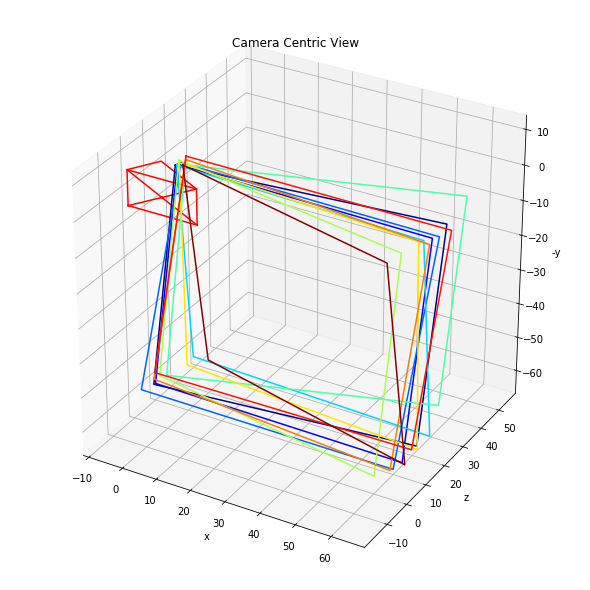

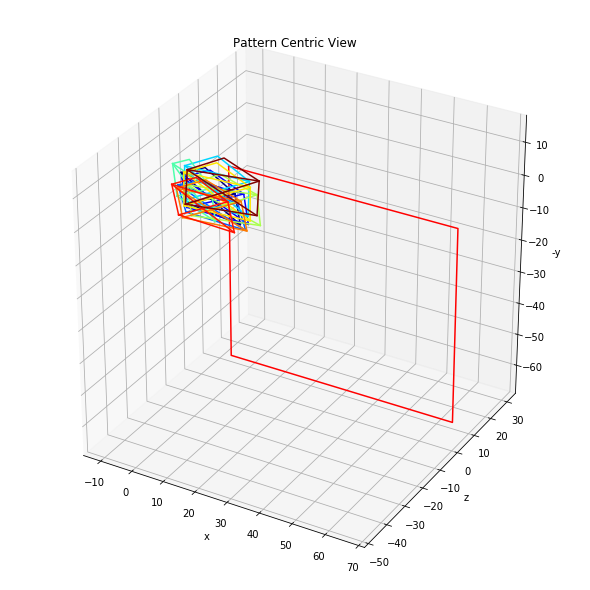

In [0]:

visualize_calibration_boards(camera_matrix,
                        rvecs,tvecs)